**US Traffic Accidents Severity Classification**

1) Import All libraries

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

2) Load Original Data

In [0]:
DfUSAccidents = pd.read_csv('US_Accidents_Dec19.csv')

3) Drop unnecessary columns. Feature generation and analysis stage
First I don't need some of these features, also, some of these appear to be more trouble than they're worth

In [0]:
DfUSAccidents = DfUSAccidents.drop(columns=['TMC','Source','Number','Country'])

In [0]:
DfUSAccidents = DfUSAccidents.drop(columns=['End_Lat','End_Lng'])

Now, we come to Date-Time. This just needs to be broken apart and put back together in a more useful form (integer)

In [0]:
DfUSAccidentsTime = DfUSAccidents.Start_Time.str.split("-",expand=True)

In [0]:
DfUSAccidentsTime.rename(columns={0: 'Year', 1: 'Month', 2: 'ToSplit2'}, inplace =True)

In [0]:
DfUSAccidentsTime2 = DfUSAccidentsTime.ToSplit2.str.split(expand=True)

In [0]:
DfUSAccidentsTime2.rename(columns={0:'Day', 1:'TimetoSplit'}, inplace=True)

In [0]:
DfUSAccidentsTime3 = DfUSAccidentsTime2.TimetoSplit.str.split(":",expand=True)
DfUSAccidentsTime3.rename(columns={0:'Hours',1:'Minutes', 2:'Seconds'}, inplace=True)

In [0]:
DfUSAccidentsTime.reset_index()
DfUSAccidentsTime2.reset_index()
DfUSAccidentsTime3.reset_index()
DfUSACombineTimeDate1 = pd.concat([DfUSAccidentsTime,DfUSAccidentsTime2,DfUSAccidentsTime3], axis=1).reindex(DfUSAccidentsTime.index)

In [0]:
DfUSACombineTimeDate1 = DfUSACombineTimeDate1.drop(columns=['ToSplit2','TimetoSplit'])

In [0]:
DfUSACombineTimeDate1.reset_index()
DfUSAccidents.reset_index()
DfUSACombinedDateTimeAccidents1= pd.concat([DfUSAccidents,DfUSACombineTimeDate1], axis= 1).reindex(DfUSAccidents.index)

Now that we have time and date of the traffic incident pulled from the data, time to take a look at the weather. Weather will need to be made into a numeric variable; this is likely where some of my own bias's may come in. I leveled all Weather_Conditions writen in the data between 1:7 with 1 being a clear day, and 7 being extremely dangerous weather. 

In [0]:
DFweatherratings= pd.read_csv('Weather_Conditions2.csv')
DFweatherratings.drop(DFweatherratings.columns[0], axis=1,inplace=True)
DFweatherratings.dropna()

,Weather_Condition,Level
0,Light Rain,3.0
1,Overcast,2.0
2,Mostly Cloudy,2.0
3,Rain,3.0
4,Light Snow,3.0
...,...,...
116,Thunderstorms and Snow,7.0
117,Smoke / Windy,6.0
118,Freezing Rain / Windy,6.0
119,Dust Whirls,6.0


In [0]:
DfUSACombinedDateTimeAccidentsandWeather1= pd.merge(DfUSACombinedDateTimeAccidents1,DFweatherratings, left_on='Weather_Condition',right_on='Weather_Condition', how='left')
DfUSACombinedDateTimeAccidentsandWeather1.drop(columns=['Wind_Chill(F)', 'Wind_Direction','Wind_Speed(mph)','Airport_Code','Weather_Timestamp'])



Next I believe a good feature maybe to see if the incident occurs on a highway/StateRoute vs a named road. The idea being that perhaps a highway incident maybe more severe than a non-highway incident

In [0]:
DfUSACombinedDateTimeAccidentsandWeather1['Highway/StateRoute'] = np.where(DfUSACombinedDateTimeAccidentsandWeather1['Street'].str.contains("I-|Highway|State", case=False, na=False), 1,0)

Next lets graph the data to get a better idea of some of the features, primarily I'd like to see what affect Weather has on Severity.

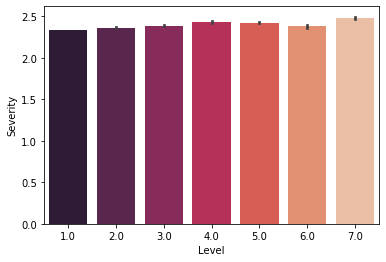

In [0]:
sns.barplot(x=DfUSACombinedDateTimeAccidentsandWeather1['Level'], y=DfUSACombinedDateTimeAccidentsandWeather1['Severity'],palette="rocket")

That's actually interesting to me, I feel pretty good about how I leveled the weather (especially in the 5-6 range). But it's interesting that there's a dip there. Thinking through this I suppose it may make since; not included in this dataset is if the individuals are distracted driving or driving unsafe for conditions prior to the incident. Here a 3-4 level is some combination of thunderstorms to light hail, which is unsafe conditions, but some individuals may see as just another day out on the road. where as 5-6 may contain any combination of freezing rain, extreme thunderstorms or extremely low visibility situations, where drivers are more likely to be driving defensively

# That's interesting, now I believe I'm ready to model!
Time to prep the dataset, first don't need ID anymore and I don't believe there's any na, but if there is I'll map to 0

In [0]:
DfUSACombinedDateTimeAccidentsandWeather1.drop(columns=['ID'])
DfUSACombinedDateTimeAccidentsandWeather1.head(3)

In [0]:
DfUSACombinedDateTimeAccidentsandWeather1=DfUSACombinedDateTimeAccidentsandWeather1.fillna(0)

Next, time to change the classification features to a more useable form for my models

In [0]:
DfUSACombinedDateTimeAccidentsandWeather1['Side'] = DfUSACombinedDateTimeAccidentsandWeather1['Side'].map({'R':0,'L':1})
DfUSACombinedDateTimeAccidentsandWeather1['Amenity'] = DfUSACombinedDateTimeAccidentsandWeather1['Amenity'].map({False:0,True:1})
DfUSACombinedDateTimeAccidentsandWeather1['Bump'] = DfUSACombinedDateTimeAccidentsandWeather1['Bump'].map({False:0,True:1})
DfUSACombinedDateTimeAccidentsandWeather1['Crossing'] = DfUSACombinedDateTimeAccidentsandWeather1['Crossing'].map({False:0,True:1})
DfUSACombinedDateTimeAccidentsandWeather1['Give_Way'] = DfUSACombinedDateTimeAccidentsandWeather1['Give_Way'].map({False:0,True:1})
DfUSACombinedDateTimeAccidentsandWeather1['No_Exit'] = DfUSACombinedDateTimeAccidentsandWeather1['No_Exit'].map({False:0,True:1})
DfUSACombinedDateTimeAccidentsandWeather1['Railway'] = DfUSACombinedDateTimeAccidentsandWeather1['Railway'].map({False:0,True:1})
DfUSACombinedDateTimeAccidentsandWeather1['Roundabout'] = DfUSACombinedDateTimeAccidentsandWeather1['Roundabout'].map({False:0,True:1})
DfUSACombinedDateTimeAccidentsandWeather1['Station'] = DfUSACombinedDateTimeAccidentsandWeather1['Station'].map({False:0,True:1})
DfUSACombinedDateTimeAccidentsandWeather1['Stop'] = DfUSACombinedDateTimeAccidentsandWeather1['Stop'].map({False:0,True:1})
DfUSACombinedDateTimeAccidentsandWeather1['Traffic_Calming'] = DfUSACombinedDateTimeAccidentsandWeather1['Traffic_Calming'].map({False:0,True:1})
DfUSACombinedDateTimeAccidentsandWeather1['Traffic_Signal'] = DfUSACombinedDateTimeAccidentsandWeather1['Traffic_Signal'].map({False:0,True:1})
DfUSACombinedDateTimeAccidentsandWeather1['Turning_Loop'] = DfUSACombinedDateTimeAccidentsandWeather1['Turning_Loop'].map({False:0,True:1})
DfUSACombinedDateTimeAccidentsandWeather1['Junction'] = DfUSACombinedDateTimeAccidentsandWeather1['Junction'].map({False:0,True:1})

In [0]:
DfUSACombinedDateTimeAccidentsandWeather1['Sunrise_Sunset'] = DfUSACombinedDateTimeAccidentsandWeather1['Sunrise_Sunset'].map({'Night':0,'Day':1})
DfUSACombinedDateTimeAccidentsandWeather1['Civil_Twilight'] = DfUSACombinedDateTimeAccidentsandWeather1['Civil_Twilight'].map({'Night':0,'Day':1})
DfUSACombinedDateTimeAccidentsandWeather1['Nautical_Twilight'] = DfUSACombinedDateTimeAccidentsandWeather1['Nautical_Twilight'].map({'Night':0,'Day':1})
DfUSACombinedDateTimeAccidentsandWeather1['Astronomical_Twilight'] = DfUSACombinedDateTimeAccidentsandWeather1['Astronomical_Twilight'].map({'Night':0,'Day':1})
DfUSACombinedDateTimeAccidentsandWeather1['Year'] = DfUSACombinedDateTimeAccidentsandWeather1['Year'].map({'2014':2014,'2015':2015, '2016':2016,'2017':2017,'2018':2018,'2019':2019,'2013':2013,'2012':2012,'2011':2011,'2010':2010})
DfUSACombinedDateTimeAccidentsandWeather1['Month'] = DfUSACombinedDateTimeAccidentsandWeather1['Month'].map({'01':1,'02':2, '03':3,'04':4,'05':5,'06':6,'07':7,'08':8,'09':9,'10':10, '11':11,'12':12})


And now I'll convert the string variables to int variables

In [0]:
DfUSACombinedDateTimeAccidentsandWeather1['Day']=DfUSACombinedDateTimeAccidentsandWeather1['Day'].astype(int)


In [0]:
DfUSACombinedDateTimeAccidentsandWeather1['Hours']=DfUSACombinedDateTimeAccidentsandWeather1['Hours'].astype(int)
DfUSACombinedDateTimeAccidentsandWeather1['Minutes']=DfUSACombinedDateTimeAccidentsandWeather1['Minutes'].astype(int)
DfUSACombinedDateTimeAccidentsandWeather1['Seconds']=DfUSACombinedDateTimeAccidentsandWeather1['Seconds'].astype(int)
DfUSACombinedDateTimeAccidentsandWeather2= DfUSACombinedDateTimeAccidentsandWeather1.drop(columns=['Start_Time','End_Time','Description','Street','Timezone','City','County','Airport_Code','Weather_Timestamp','Wind_Direction','Weather_Condition'])


In [0]:
DfUSACombinedDateTimeAccidentsandWeather2['Zipcode'] =DfUSACombinedDateTimeAccidentsandWeather2['Zipcode'].str[:5]

In [0]:
DfUSACombinedDateTimeAccidentsandWeather3= DfUSACombinedDateTimeAccidentsandWeather2.drop(DfUSACombinedDateTimeAccidentsandWeather2.columns[0],axis=1)
DfUSACombinedDateTimeAccidentsandWeather3.head(2)

In [0]:
DfUSACombinedDateTimeAccidentsandWeather4= DfUSACombinedDateTimeAccidentsandWeather3.drop(DfUSACombinedDateTimeAccidentsandWeather3.columns[5],axis=1)

Nice that looks better. Although state may have been nice to keep, it feels a bit redundant with the Zipcode and Lat/Long there aswell.

That's alot of data changes that, even in python, took along time (also my complexity and memory is likely garbage up to here, but I'm not looking for long term usage with this model just a one time run-through... either way, probably good to save this as a checkpoint incase my ram crashes.

In [0]:
DfUSACombinedDateTimeAccidentsandWeather4.to_csv('Checkpoint1.csv')

In [0]:
DfUSAccidentsCleaned = pd.read_csv('Checkpoint1.csv')

Now after a final look, I missed a few columns that I'd assumed were int already, no worries this is an easy fix

In [0]:
DfUSAccidentsCleaned['Start_Lat'] = DfUSAccidentsCleaned['Start_Lat'].astype(int)
DfUSAccidentsCleaned['Start_Lng'] = DfUSAccidentsCleaned['Start_Lng'].astype(int)
DfUSAccidentsCleaned['Wind_Chill(F)'] = DfUSAccidentsCleaned['Wind_Chill(F)'].astype(int)
DfUSAccidentsCleaned['Temperature(F)'] = DfUSAccidentsCleaned['Temperature(F)'].astype(int)
DfUSAccidentsCleaned['Distance(mi)'] = DfUSAccidentsCleaned['Distance(mi)'].astype(int)

There's like 3 null values left in the entire dataset, don't really feel like doing a comprehensive look at it, I'll just fill these as 0, with 3 Million records, this isn't likely to have a major impact on the data.
 
 
 
Also, thinking through the model, I want to go ahead and limit some of the variability:

Since I already have **Lat and Long** of the accident, I don't believe that **Zipcode** would give too much more value, 

**Distance(mi)** may actually contain some of the answer in it so it may not be useful, 

**Wind_Chill(F)** doesn't appear to be that useful either when I already have **Temperature(F), Humidity and Pressure** in the model. 

I don't believe that **Year** would be useful as I don't want the model to be affected from year to year but rather give general suggestions.

To limit variability, I'll also eliminate **Minutes and Seconds** from the data as I wouldn't want the model to vary it's assessment every few seconds but rather give generalities about say commuting hours.

In [0]:
DfUSAccidentsCleaned=DfUSAccidentsCleaned.fillna(0)
DfUSAccidentsCleaned=DfUSAccidentsCleaned.drop(columns=['Year','Minutes','Seconds','Wind_Chill(F)','Distance(mi)','Zipcode'])

That looks pretty good, now let's split and begin looking at models, I'll probably stop if I get one that is over 95% accurate as I'm mainly looking for the important features out of the model.

In [0]:
y = DfUSAccidentsCleaned.Severity

x_train, x_test, y_train, y_test = train_test_split(DfUSAccidentsCleaned, y, test_size=0.2)
x_train=x_train.drop(columns=['Severity'],axis=1)
x_train=x_train.drop(x_train.columns[0], axis=1)
x_test=x_test.drop(columns=['Severity'],axis=1)
x_test=x_test.drop(x_test.columns[0], axis=1)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2379468, 31) (2379468,)
(594867, 31) (594867,)


In [0]:
x_test.head(3)

,Start_Lat,Start_Lng,Side,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Month,Day,Hours,Level,Highway/StateRoute
1386936,37,-79,0.0,59,49.0,30.17,10.0,5.8,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,1.0,1.0,10,30,18,1.0,1
2973712,43,-123,0.0,58,90.0,29.67,10.0,14.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,8,22,4,2.0,1
552130,37,-77,0.0,47,71.0,29.86,10.0,7.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,12,16,15,2.0,0


In [0]:
x_train.head(3)

,Start_Lat,Start_Lng,Side,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Month,Day,Hours,Level,Highway/StateRoute
2330599,40,-73,0.0,75,84.0,29.95,10.0,4.6,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,9,7,23,2.0,0
2114843,30,-92,0.0,73,100.0,29.98,3.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,9,1,7,2.0,0
2217892,30,-88,0.0,93,63.0,30.03,10.0,9.2,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,8,17,15,2.0,1


I like to go from simplest and easiest to explain algorithm to more complex, I'll start with Logistic Regression, then go to Decision Tree, then Naive Bayes,then KNN, then I'll go to more complex such as Support Vector Machine, Random Forests and so on if none of the preceding algorithms give a good accuracy score.

In [0]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
Y_pred = logreg.predict(x_test)
acc_log = logreg.score(x_train, y_train) * 100
acc_log

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


71.5011506773783

71% is not terrible, but as seen, this data set is simply to large for this classifier, I'll revisit this if the next algorithms don't pan out.

In [0]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train,y_train)
Y_pred = decision_tree.predict(x_test)
acc_decision_tree = decision_tree.score(x_train,y_train)
acc_decision_tree

0.9844288723361693

Wow, nice that was quicker than I'd anticipated, although to be fair this data set absolutely lends itself to to a decision tree algorithm. I'm happy with that accuracy score. now time to pull out the feature importance!

In [0]:
decision_tree.feature_importances_

array([5.04894345e-02, 7.90868001e-02, 3.26380360e-02, 9.54730092e-02,
       1.03426358e-01, 1.21952692e-01, 2.30889859e-02, 7.64495570e-02,
       9.33584319e-03, 1.38624735e-03, 1.07861533e-05, 3.94678628e-03,
       6.26753832e-04, 1.09096299e-02, 2.66417036e-04, 1.09035358e-03,
       6.76321326e-06, 2.47799607e-03, 2.09943963e-03, 5.87590809e-05,
       1.99792726e-02, 0.00000000e+00, 6.15021034e-03, 4.90962238e-03,
       4.30105420e-03, 4.15416379e-03, 4.78766703e-02, 9.18349895e-02,
       8.03324703e-02, 2.06113199e-02, 1.05029579e-01])

Interesting, as suspected, Highway/StateRoute plays a big role, so does location and weather. If I were to deploy this model I would utilize it as an app or in a logistics algorithm for a trucking company to show if there were an accident at this location or this time it is likely to have be ___ severe

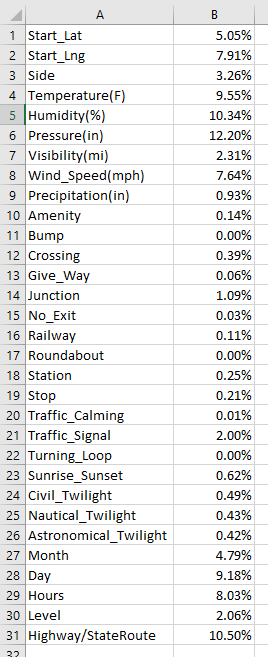